### Packages

In [1]:
# Essentials
import pandas as pd
import numpy as np

# ML Modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# For preprosessing
import string
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

# For testing coherence model
import gensim
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Graphs
import matplotlib.pyplot as plt

### Data Import

In [3]:
url = 'https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/10-Natural-Language-Processing/lda_data'

data = pd.read_csv(url, sep=",", header=None)
data.columns = ['text']
data.head()

,text
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...
1,From: atterlep@vela.acs.oakland.edu (Cardinal ...
2,From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...
3,From: atterlep@vela.acs.oakland.edu (Cardinal ...
4,From: vzhivov@superior.carleton.ca (Vladimir Z...


### Preprocessing

In [4]:
def preprocessing(sentence):
    
    # remove whitespace
    sentence = sentence.strip()
    
    # lowercase characters
    sentence = sentence.lower()
    
    # remove numbers
    sentence = ''.join(char for char in sentence if not char.isdigit())
    
    # remove punctuation
    for punctuation in string.punctuation:   
        sentence = sentence.replace(punctuation, '')
    
    # remove stop_words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    sentence = ' '.join(filtered_words)
    
    # tokenize and lemmatize
    words = word_tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]  # Lemmatize verbs
    lemmatized_words = [lemmatizer.lemmatize(word, pos='n') for word in lemmatized_words]  # Lemmatize nouns
    
    return ' '.join(lemmatized_words)

Test data:

In [5]:
data['clean_text'] = data['text'].apply(preprocessing)
data

,text,clean_text
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,gldcunixbcccolumbiaedu gary l dare subject sta...
1,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenez sub...
2,From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...,minerkuhubccukansedu subject ancient book orga...
3,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenez sub...
4,From: vzhivov@superior.carleton.ca (Vladimir Z...,vzhivovsuperiorcarletonca vladimir zhivov subj...
...,...,...
1194,From: jerryb@eskimo.com (Jerry Kaufman)\nSubje...,jerrybeskimocom jerry kaufman subject prayer a...
1195,From: golchowy@alchemy.chem.utoronto.ca (Geral...,golchowyalchemychemutorontoca gerald olchowy s...
1196,From: jayne@mmalt.guild.org (Jayne Kulikauskas...,jaynemmaltguildorg jayne kulikauskas subject q...
1197,From: sclark@epas.utoronto.ca (Susan Clark)\nS...,sclarkepasutorontoca susan clark subject pick ...


### Functions

In [6]:
def lda_model_fit(n_components, max_iter, vectorized_documents):
    lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = max_iter) 
    
    # Fit the LDA on the vectorized documents 
    lda_model.fit(vectorized_documents)
    
    return lda_model

In [7]:
def topics_list(model, vectorizer, top_words):
    topics = []
    for idx, topic in enumerate(model.components_):
        # print("Topic %d:" % (idx))
        topic = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_words - 1:-1]]
        # print(topic)
        topics.append(topic)
    return topics

In [8]:
def print_topics(model, vectorizer):
    topics = []
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        topic = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-10 - 1:-1]]
        print(topic)
        topics.append(topic)
    return topics

In [9]:
def graph_topics(topics):
    # Calculating the number of rows and columns
    num_sets = len(topics)
    num_cols = 2  # Number of columns you want
    num_rows = -(-num_sets // num_cols)  # Ceiling division to ensure enough rows
    
    # Plotting each data set
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
    for i, data in enumerate(topics):
        row = i // num_cols
        col = i % num_cols
        labels = [item[0] for item in data]
        values = [item[1] for item in data]
        axs[row, col].barh(labels, values, color='skyblue')
        axs[row, col].set_ylabel('Keywords')
        axs[row, col].set_title('Topic {}'.format(i))
        axs[row, col].invert_yaxis()
    
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

In [30]:
def lda_model_transform(model, vectorized_documents, original_DF):
    document_topic_mixture = model.transform(vectorized_documents)
    R, T = document_topic_mixture.shape

    #create new column with the topic number
    max_indices = np.argmax(document_topic_mixture, axis=1)
    new_column = max_indices[:, np.newaxis]
    document_topic_mixture_cluster_n = np.concatenate((document_topic_mixture, new_column), axis=1)

    #transform the array to DF  
    columns = ['topic_{}'.format(i) for i in range(3)] + ['Main_Topic']
    df_array = pd.DataFrame(document_topic_mixture_cluster_n, columns=columns)

    #merge original DataFrame with this
    merged_df = pd.concat([original_DF, df_array], axis=1)

    # meed to return the max column
    # return document_topic_mixture
    # return document_topic_mixture_cluster_n
    return merged_df
    

### Run LDA to see the topics

In [11]:
vectorizer = TfidfVectorizer(min_df = 0.10, max_df = 0.9, max_features = 200)

vectorized_documents = vectorizer.fit_transform(data['clean_text'])

In [12]:
vectorized_documents.shape

(1199, 156)

In [13]:
model1 = lda_model_fit(3, 100, vectorized_documents)

In [14]:
topics1 = print_topics(model1, vectorizer)

Topic 0:
[('team', 77.51784745067656), ('game', 77.15813683950363), ('play', 58.532327156115585), ('hockey', 55.23260700480893), ('go', 53.369307533962456), ('player', 51.31482627152931), ('win', 42.99098505691661), ('get', 42.39611204049453), ('nhl', 39.82967801196302), ('year', 39.467477477796706)]
Topic 1:
[('university', 32.805573301162376), ('please', 31.768184236411482), ('replyto', 26.83952276335106), ('st', 25.801331303736276), ('thank', 25.61559661370624), ('state', 25.090747734309318), ('post', 24.30305476963541), ('anyone', 23.380704910662534), ('pittsburgh', 15.769344064304457), ('john', 14.606803790486751)]
Topic 2:
[('god', 92.61047344311937), ('christian', 59.906244086527195), ('people', 49.73295132874696), ('would', 48.600926447527684), ('church', 47.47587436575051), ('jesus', 47.423779218221114), ('say', 47.05711998741401), ('one', 47.01895401481158), ('know', 43.67396025925074), ('believe', 41.8826082195713)]


In [15]:
topics1

[[('team', 77.51784745067656),
  ('game', 77.15813683950363),
  ('play', 58.532327156115585),
  ('hockey', 55.23260700480893),
  ('go', 53.369307533962456),
  ('player', 51.31482627152931),
  ('win', 42.99098505691661),
  ('get', 42.39611204049453),
  ('nhl', 39.82967801196302),
  ('year', 39.467477477796706)],
 [('university', 32.805573301162376),
  ('please', 31.768184236411482),
  ('replyto', 26.83952276335106),
  ('st', 25.801331303736276),
  ('thank', 25.61559661370624),
  ('state', 25.090747734309318),
  ('post', 24.30305476963541),
  ('anyone', 23.380704910662534),
  ('pittsburgh', 15.769344064304457),
  ('john', 14.606803790486751)],
 [('god', 92.61047344311937),
  ('christian', 59.906244086527195),
  ('people', 49.73295132874696),
  ('would', 48.600926447527684),
  ('church', 47.47587436575051),
  ('jesus', 47.423779218221114),
  ('say', 47.05711998741401),
  ('one', 47.01895401481158),
  ('know', 43.67396025925074),
  ('believe', 41.8826082195713)]]

In [16]:
document_topic_mixture = model1.transform(vectorized_documents)

In [17]:
document_topic_mixture.shape

(1199, 3)

In [18]:
document_topic_mixture

array([[0.79577319, 0.1266178 , 0.07760901],
       [0.06053237, 0.06007927, 0.87938836],
       [0.0853129 , 0.04997246, 0.86471464],
       ...,
       [0.10331539, 0.07381553, 0.82286908],
       [0.80311021, 0.10189987, 0.09498992],
       [0.0647254 , 0.13663547, 0.79863912]])

In [20]:
max_indices = np.argmax(document_topic_mixture, axis=1)
new_column = max_indices[:, np.newaxis]
document_topic_mixture_cluster_n = np.concatenate((document_topic_mixture, new_column), axis=1)
document_topic_mixture_cluster_n

array([[0.79577319, 0.1266178 , 0.07760901, 0.        ],
       [0.06053237, 0.06007927, 0.87938836, 2.        ],
       [0.0853129 , 0.04997246, 0.86471464, 2.        ],
       ...,
       [0.10331539, 0.07381553, 0.82286908, 2.        ],
       [0.80311021, 0.10189987, 0.09498992, 0.        ],
       [0.0647254 , 0.13663547, 0.79863912, 2.        ]])

In [25]:
columns = ['topic_{}'.format(i) for i in range(3)] + ['Main_Topic']
df_array = pd.DataFrame(document_topic_mixture_cluster_n, columns=columns)
df_array

,topic_0,topic_1,topic_2,Main_Topic
0,0.795773,0.126618,0.077609,0.0
1,0.060532,0.060079,0.879388,2.0
2,0.085313,0.049972,0.864715,2.0
3,0.076991,0.081946,0.841063,2.0
4,0.843699,0.083580,0.072721,0.0
...,...,...,...,...
1194,0.097756,0.086512,0.815731,2.0
1195,0.807000,0.073362,0.119638,0.0
1196,0.103315,0.073816,0.822869,2.0
1197,0.803110,0.101900,0.094990,0.0


In [27]:
merged_df = pd.concat([data, df_array], axis=1)
merged_df

,text,clean_text,topic_0,topic_1,topic_2,Main_Topic
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,gldcunixbcccolumbiaedu gary l dare subject sta...,0.795773,0.126618,0.077609,0.0
1,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenez sub...,0.060532,0.060079,0.879388,2.0
2,From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...,minerkuhubccukansedu subject ancient book orga...,0.085313,0.049972,0.864715,2.0
3,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenez sub...,0.076991,0.081946,0.841063,2.0
4,From: vzhivov@superior.carleton.ca (Vladimir Z...,vzhivovsuperiorcarletonca vladimir zhivov subj...,0.843699,0.083580,0.072721,0.0
...,...,...,...,...,...,...
1194,From: jerryb@eskimo.com (Jerry Kaufman)\nSubje...,jerrybeskimocom jerry kaufman subject prayer a...,0.097756,0.086512,0.815731,2.0
1195,From: golchowy@alchemy.chem.utoronto.ca (Geral...,golchowyalchemychemutorontoca gerald olchowy s...,0.807000,0.073362,0.119638,0.0
1196,From: jayne@mmalt.guild.org (Jayne Kulikauskas...,jaynemmaltguildorg jayne kulikauskas subject q...,0.103315,0.073816,0.822869,2.0
1197,From: sclark@epas.utoronto.ca (Susan Clark)\nS...,sclarkepasutorontoca susan clark subject pick ...,0.803110,0.101900,0.094990,0.0


In [21]:
document_topic_mixture_cluster_n.shape

(1199, 4)

In [31]:
document_topic_mixture_cluster_n_1 = lda_model_transform(model1, vectorized_documents, data)

In [32]:
document_topic_mixture_cluster_n_1

,text,clean_text,topic_0,topic_1,topic_2,Main_Topic
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,gldcunixbcccolumbiaedu gary l dare subject sta...,0.795773,0.126618,0.077609,0.0
1,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenez sub...,0.060532,0.060079,0.879388,2.0
2,From: miner@kuhub.cc.ukans.edu\nSubject: Re: A...,minerkuhubccukansedu subject ancient book orga...,0.085313,0.049972,0.864715,2.0
3,From: atterlep@vela.acs.oakland.edu (Cardinal ...,atterlepvelaacsoaklandedu cardinal ximenez sub...,0.076991,0.081946,0.841063,2.0
4,From: vzhivov@superior.carleton.ca (Vladimir Z...,vzhivovsuperiorcarletonca vladimir zhivov subj...,0.843699,0.083580,0.072721,0.0
...,...,...,...,...,...,...
1194,From: jerryb@eskimo.com (Jerry Kaufman)\nSubje...,jerrybeskimocom jerry kaufman subject prayer a...,0.097756,0.086512,0.815731,2.0
1195,From: golchowy@alchemy.chem.utoronto.ca (Geral...,golchowyalchemychemutorontoca gerald olchowy s...,0.807000,0.073362,0.119638,0.0
1196,From: jayne@mmalt.guild.org (Jayne Kulikauskas...,jaynemmaltguildorg jayne kulikauskas subject q...,0.103315,0.073816,0.822869,2.0
1197,From: sclark@epas.utoronto.ca (Susan Clark)\nS...,sclarkepasutorontoca susan clark subject pick ...,0.803110,0.101900,0.094990,0.0


In [11]:
# Instantiate the LDA
n_components = 5 
lda_model = LatentDirichletAllocation(n_components=n_components, max_iter = 100) 

# Fit the LDA on the vectorized documents 
lda_model.fit(vectorized_documents)

LatentDirichletAllocation(max_iter=100, n_components=5)

In [94]:
topics = topics_list(lda_model, vectorizer, 5)

In [70]:
type(topics)

list

In [76]:
type(topics[0])

list

In [77]:
type(topics[0][0])

tuple

In [78]:
topics[0][0]

('name', 29.173949181121092)

In [74]:
len(topics)

5

In [75]:
topics

[[('name', 29.173949181121092),
  ('fan', 2.9975250073677477),
  ('like', 1.8111830960960629),
  ('cant', 1.2633818593976753),
  ('try', 0.8798763292386389),
  ('player', 0.7661226032126869),
  ('university', 0.7615216945899945),
  ('good', 0.7435928375581566),
  ('know', 0.5957952631077141),
  ('say', 0.5557652972183227)],
 [('church', 8.168604837722954),
  ('world', 4.461748757410106),
  ('replyto', 2.7565846185475524),
  ('game', 2.7305074566712997),
  ('anyone', 2.506375382583701),
  ('show', 2.2480285037933028),
  ('another', 2.2480231814738114),
  ('university', 2.08388548332709),
  ('would', 1.8804196052157496),
  ('bible', 1.701375227612775)],
 [('please', 25.107888880007135),
  ('thank', 19.348272412172385),
  ('university', 14.811721647085578),
  ('post', 9.905687491299032),
  ('pittsburgh', 8.958080375060495),
  ('nntppostinghost', 6.699890502577248),
  ('anyone', 6.0294331211691645),
  ('state', 4.018789664717768),
  ('replyto', 3.8436525929691268),
  ('time', 3.30373169974

In [45]:
lda_model.components_.shape

(5, 156)

In [50]:
vectorizer.get_feature_names_out().shape

(156,)

In [68]:
lda_model.components_[1].sum()

71.11508219042226

### Latent Dirichlet Allocation model for optimal number of topics (using Perplexity)

In [22]:
corpus = gensim.matutils.Sparse2Corpus(vectorized_documents, documents_columns=False)

In [24]:
dictionary = Dictionary.from_corpus(corpus, id2word=dict(enumerate(vectorizer.get_feature_names_out())))

In [25]:
# Function to compute perplexity values for a given LDA model
def compute_perplexity_values(corpus, dictionary, limit, start=2, step=3):
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        perplexity_values.append(model.log_perplexity(corpus))
    return perplexity_values

In [28]:
def compute_coherence_values(corpus, dictionary, texts, limit, start=2, step=3):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return coherence_values

In [33]:
# Calculate perplexity values for different numbers of topics
start = 20
limit = 60
step = 2
perplexity_values = compute_perplexity_values(corpus, dictionary, limit, start, step)

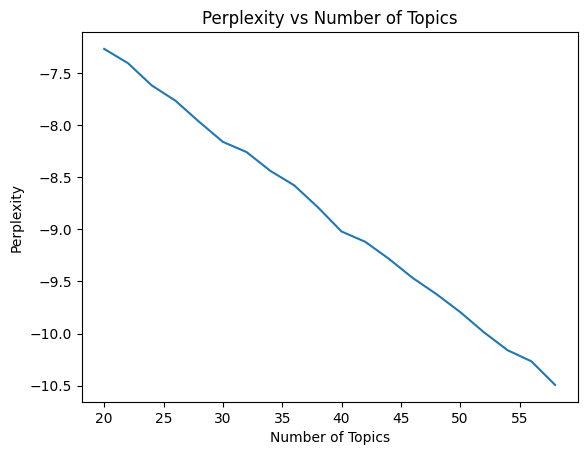

In [34]:
# Plot perplexity values
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Number of Topics")
plt.show()

### Visualization

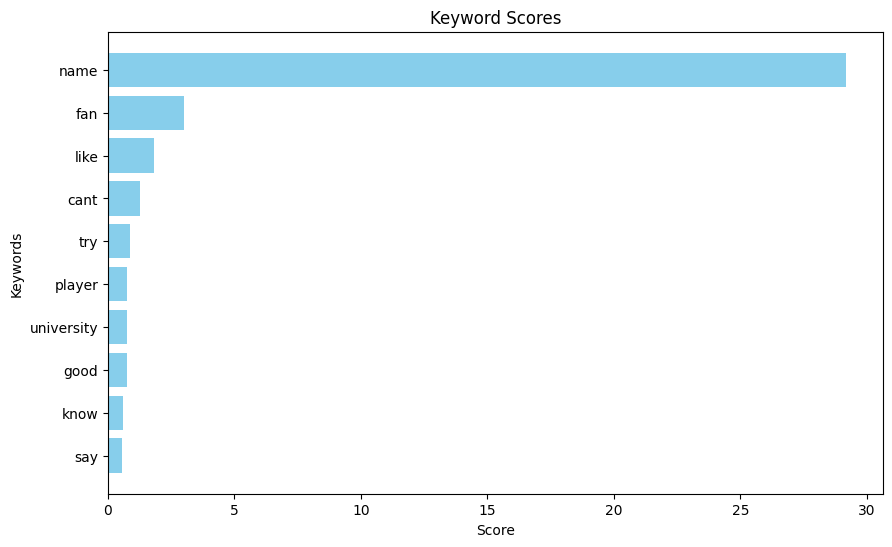

In [84]:
data = topics[0]

labels = [item[0] for item in data]
values = [item[1] for item in data]

# Creating bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Score')
plt.ylabel('Keywords')
plt.title('Keyword Scores')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

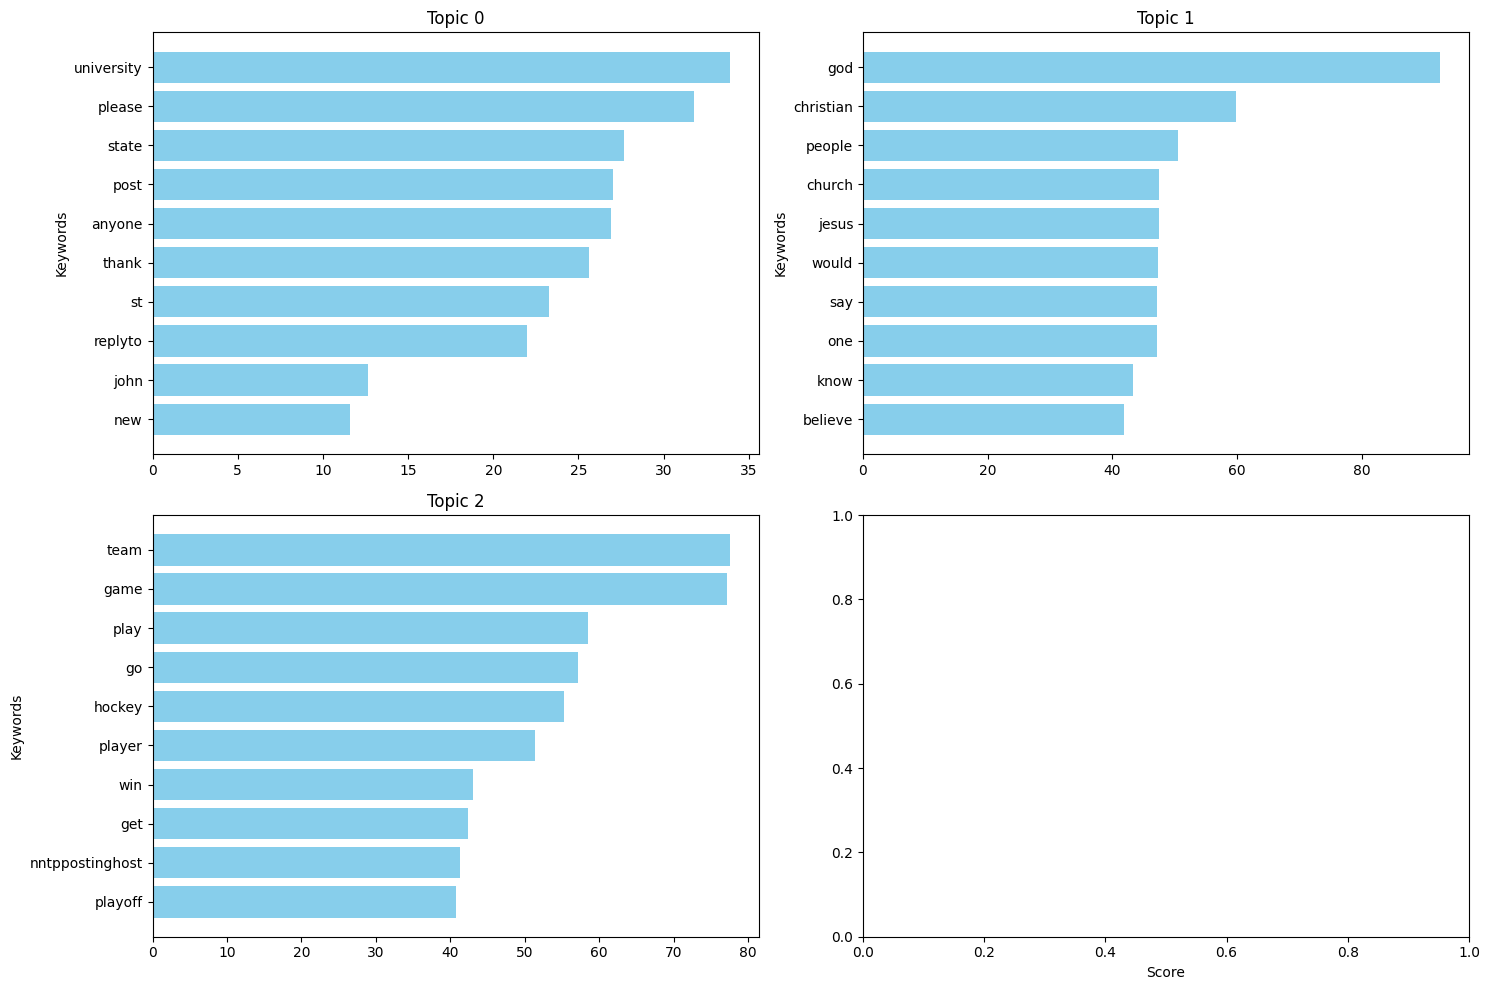

In [15]:
graph_topics(topics1)